In [155]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.nn.ghostG import GhostGutzwiller
from gGA.utils.tools import setup_seed
from gGA.utils.tools import get_semicircle_e_list
import numpy as np
from gGA.data import _keys

setup_seed(124)

torch.set_default_dtype(torch.float64)
U = 1.0
J = 0.1 * U # 0.25 * U
Up = U - 2*J
Jp = 2*J

alpha = 0.2
V = 1.0
ep = -1.0
e_list = get_semicircle_e_list(nmesh=1000)

eks = np.zeros((len(e_list), 5, 5))+0j
eks += np.array([[[ 0,   0,   V,  0,  V/2],
                [ 0,   0,   0,  V,  V/2],
                [ V,   0,   ep, 0,  0],
                [ 0,   V,   0,  ep, 0],
                [ V/2, V/2, 0,  0,  ep]]],dtype=np.complex128)
eks[:,:2,:2] += alpha * e_list[:,None,None] * np.eye(2).reshape(1,2,2)
eks[:,-3:,-3:] += e_list[:,None,None] * np.eye(3).reshape(1,3,3)

phy_onsite = {
    "C": torch.zeros(1, 5, 5)
}

intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]}

print(intparams)

gga = GhostGutzwiller(
    atomic_number=torch.tensor([6]),
    nocc=8,
    basis={"C":[2,3]},
    idx_intorb={"C":[0]},
    naux=2,
    intparams=intparams,
    nspin=1,
    device=torch.device("cpu"),
    kBT=0.0002,
    mutol=1e-5,
    solver="ED",
    mixer_options={"method": "Linear", "a": 0.9},
    iscomplex=False,
    solver_options={},
)

# hop = - torch.diag(torch.tensor([0., 1.])) * (1/6)
# # hop = torch.stack([hop, torch.zeros_like(hop), torch.zeros_like(hop), hop]).reshape(2,2,2,2).permute(2,0,3,1).reshape(4,4)

# on = torch.tensor([-U/2, V, V, ep]).reshape(2,2)
# # on = torch.stack([on, torch.zeros_like(on), torch.zeros_like(on), on]).reshape(2,2,2,2).permute(2,0,3,1).reshape(4,4)

# block = {
#     "0_0_0_0_0": on,
#     "0_0_0_0_1": hop,
#     "0_0_0_1_0": hop,
#     "0_0_1_0_0": hop
# }

atomicdata = AtomicData.from_ase(
    read("/nessa/users/zhanghao/dev/Hubbard/gGA/test/C_cube.vasp"),
    r_max=3.1
    )

# atomicdata["kpoint"] = torch.tensor(kmesh_sampling([10,10,10], True)).to(torch.get_default_dtype())
# block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)
atomicdata[_keys.HAMILTONIAN_KEY] = torch.from_numpy(eks)
atomicdata[_keys.PHY_ONSITE_KEY] = phy_onsite

{'C': [{'U': 1.0, 'Up': 0.8, 'J': 0.1, 'Jp': 0.2}]}


In [ ]:
gga.run(atomicdata, 200, 1e-4)

Find E_fermi: 0.1344
DM_kin:  tensor([6.8462e-04, 6.8462e-04, 1.6161e-01, 1.6161e-01, 8.3933e-01, 8.3933e-01,
        9.9899e-01, 9.9899e-01, 9.9938e-01, 9.9938e-01, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00])
DM_emb:  tensor([4.3131e-06, 4.3131e-06, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01,
        1.6667e-01, 1.6667e-01, 2.3027e-01, 2.3027e-01, 2.5546e-01, 2.5546e-01,
        1.0000e+00, 1.0000e+00])
 -- Current error: 1.62653
Find E_fermi: 1.1055
DM_kin:  tensor([0.0013, 0.0013, 0.0824, 0.0824, 0.9187, 0.9187, 0.9977, 0.9977, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
DM_emb:  tensor([0.0124, 0.0124, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.2578,
        0.2578, 0.4278, 0.4278, 0.9999, 0.9999])
 -- Current error: 1.71840
Find E_fermi: 1.2718
DM_kin:  tensor([0.0028, 0.0028, 0.1896, 0.1896, 0.8095, 0.8095, 0.9984, 0.9984, 0.9998,
        0.9998, 1.0000, 1.0000, 1.0000, 1.0000])
DM_emb:  tensor([0.0165, 0.0165, 0.1667, 0.1667, 0.1667, 0.1667, 

In [148]:
gga.gGAtomic.docc

{'C': tensor([[0.1144, 0.1144, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])}

In [ ]:
U = 1.0
J = 0.1 * U # 0.25 * U
Up = U - 2*J
Jp = 2*J
intparams = {"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]}
gga.update_intparam(intparams)
gga.run(atomicdata, 200, 1e-4)

Find E_fermi: 1.8615
DM_kin:  tensor([9.5548e-04, 9.5548e-04, 3.6013e-01, 3.6013e-01, 6.4311e-01, 6.4311e-01,
        9.9604e-01, 9.9604e-01, 9.9980e-01, 9.9980e-01, 9.9997e-01, 9.9997e-01,
        1.0000e+00, 1.0000e+00])
DM_emb:  tensor([0.0173, 0.0173, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.4418,
        0.4418, 0.6888, 0.6888, 0.9970, 0.9970])
Convergence achieved!

Convergened Density:  {'C': tensor([[[ 5.7614e-01,  0.0000e+00, -1.1869e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  5.7614e-01,  0.0000e+00, -1.1869e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.1869e-01,  0.0000e+00,  5.6876e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.1869e-01,  0.0000e+00,  5.6876e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00

In [157]:
GF = gga.compute_GF(Es=torch.linspace(-5,5, 1000), data=atomicdata, eta=1e-4)
ARPES = GF.imag.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)**2

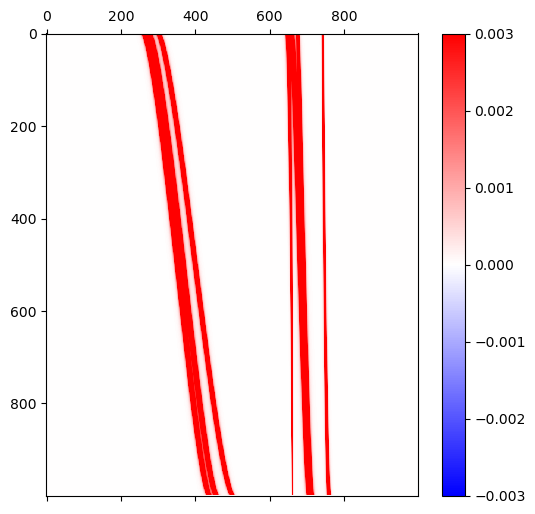

In [158]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))
m = ax.matshow(ARPES, cmap="bwr", vmin=-3e-3, vmax=3e-3)
ax.set_aspect('auto')  # override the default 'equal'
fig.colorbar(m)
plt.show()

In [7]:
gga.R["C"][0].T @ gga.R["C"][0]

tensor([[0.9175, 0.0000, 0.0365, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9175, 0.0000, 0.0365, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0365, 0.0000, 0.9500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0365, 0.0000, 0.9500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]])